# TUTO Multi-pitch Estimation

2024-05-29

see Rachel /Users/peeters/_work/_develop/_python/_import/_pytorch_ismir2021/ismir-2021-tutorial-case-studies/pitch_tracking

## Import package

In [1]:
import torch
from torch import nn
import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim


import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from argparse import Namespace


import librosa
import matplotlib.pyplot as plt
import numpy as np

from argparse import Namespace

## Get datasets

Which are the existing datasets

pyjama, hdf5, ...

In [2]:
ROOT = '/tsi/data_doctorants/gpeeters/_data/'

#base, do_f0_annot_frame1_segment2 = 'bach10', 1
base, do_f0_annot_frame1_segment2 = 'maps', 2

hdf5_audio_file = f'{ROOT}/{base}_audio.hdf5'
hdf5_feat_file = f'{ROOT}/{base}_feat.hdf5'
pyjama_annot_file = f'{ROOT}/{base}.pyjama'

with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
audiofile_l = [entry['filepath'][0]['value'] for entry in data_d['collection']['entry']]
pp.pprint(audiofile_l[:5])

with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    pp.pprint(hdf5_fid[audiofile_l[0]][:].shape)
    pp.pprint(hdf5_fid[audiofile_l[0]].attrs['sr_hz'])
    pp.pprint(hdf5_fid['/'].keys())

['MAPS_MUS-alb_se3_AkPnBcht.wav',
 'MAPS_MUS-bach_846_AkPnBcht.wav',
 'MAPS_MUS-bach_847_AkPnBcht.wav',
 'MAPS_MUS-bk_xmas5_AkPnBcht.wav',
 'MAPS_MUS-chp_op31_AkPnBcht.wav']
(5514216,)
22050
<KeysViewHDF5 ['MAPS_MUS-alb_esp2_AkPnCGdD.wav', 'MAPS_MUS-alb_esp2_AkPnStgb.wav', 'MAPS_MUS-alb_esp2_SptkBGAm.wav', 'MAPS_MUS-alb_esp2_SptkBGCl.wav', 'MAPS_MUS-alb_esp3_AkPnCGdD.wav', 'MAPS_MUS-alb_esp4_AkPnStgb.wav', 'MAPS_MUS-alb_esp5_SptkBGCl.wav', 'MAPS_MUS-alb_esp6_SptkBGCl.wav', 'MAPS_MUS-alb_se2_ENSTDkCl.wav', 'MAPS_MUS-alb_se2_StbgTGd2.wav', 'MAPS_MUS-alb_se3_AkPnBcht.wav', 'MAPS_MUS-alb_se3_AkPnBsdf.wav', 'MAPS_MUS-alb_se4_AkPnBsdf.wav', 'MAPS_MUS-alb_se6_AkPnStgb.wav', 'MAPS_MUS-alb_se7_AkPnBsdf.wav', 'MAPS_MUS-alb_se8_SptkBGAm.wav', 'MAPS_MUS-appass_1_AkPnBsdf.wav', 'MAPS_MUS-appass_1_SptkBGCl.wav', 'MAPS_MUS-appass_3_AkPnStgb.wav', 'MAPS_MUS-bach_846_AkPnBcht.wav', 'MAPS_MUS-bach_846_SptkBGAm.wav', 'MAPS_MUS-bach_847_AkPnBcht.wav', 'MAPS_MUS-bach_847_AkPnStgb.wav', 'MAPS_MUS-bach_847_S

## Get input representation

Compare 
- Log-Mel-Spectrogram
- CQT
- HCQT
- 1D, SincNet, Harmonic-Sinc-Net

In [3]:
midi_to_f0 = lambda midi: 440*2**((midi-69)/12)
f0_to_midi = lambda f0: np.log2(f0/440)*12+69
flog = lambda x: np.log(1+1000*x)-np.log(1+1000)

### Get HCQT

In [4]:
def f_get_hcqt(audio_v, sr_hz):
    """
    """
    h_l = [0.5, 1, 2, 3, 4, 5]
    BINS_PER_SEMITONE = 5
    BINS_PER_OCTAVE = 12 * BINS_PER_SEMITONE
    N_OCTAVES = 6
    N_BINS = N_OCTAVES * BINS_PER_OCTAVE
    FMIN = 32.7
    HOP_LENGTH = 512
    
    for idx, h in enumerate(h_l):
        A_m = np.abs(librosa.cqt(y=audio_v, sr=sr_hz, fmin=h*32.7, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE, n_bins=N_BINS))
        if idx==0: CQT_3m = np.zeros((len(h_l), A_m.shape[0], A_m.shape[1]))
        CQT_3m[idx,:,:] = A_m
    
    n_times = CQT_3m.shape[2]
    cqt_time_sec_v = librosa.frames_to_time(np.arange(n_times), sr=sr_hz, hop_length=HOP_LENGTH)
    cqt_frequency_hz_v = librosa.cqt_frequencies(n_bins=N_BINS, fmin=FMIN, bins_per_octave=BINS_PER_OCTAVE)

    return CQT_3m, cqt_time_sec_v, cqt_frequency_hz_v


# --------------
# TEST
# --------------
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    CQT_3m, cqt_time_sec_v, cqt_frequency_hz_v = f_get_hcqt(hdf5_fid[audiofile_l[0]][:], hdf5_fid[audiofile_l[0]].attrs['sr_hz'])
print(f'{CQT_3m.shape} {cqt_frequency_hz_v[0], cqt_frequency_hz_v[-1]}')

(6, 360, 10770) (32.7, 2068.7621417945415)


### Batch/parrallel processing of feature extraction

In [89]:
from multiprocessing import Pool
import os
directory_path = './_tmp/'

def f_parrallel(audio_file):
    """
    """
    with h5py.File(hdf5_audio_file, 'r') as audio_fid:
        audio_value_v = audio_fid[audio_file][:]
        audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
        cqt_value_3m, cqt_time_sec_v, cqt_frequency_hz_v = f_get_hcqt(audio_value_v, audio_sr_hz)
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
        np.savez(f"{directory_path}/{audio_file}.npz", cqt_value_3m=cqt_value_3m, cqt_time_sec_v=cqt_time_sec_v, cqt_frequency_hz_v=cqt_frequency_hz_v)

with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_file_l = [audio_file for audio_file in hdf5_fid['/'].keys()]
print(audio_file_l)

with Pool(16) as p: p.map(f_parrallel, audio_file_l)

with h5py.File(hdf5_feat_file, 'w') as feat_fid:
    for audio_file in tqdm(audio_file_l):
        data = np.load(f"{directory_path}/{audio_file}.npz")
        feat_fid['/' + audio_file + '/cqt_value_3m/'] = data['cqt_value_3m']
        feat_fid['/' + audio_file + '/cqt_time_sec_v/'] = data['cqt_time_sec_v']
        feat_fid['/' + audio_file + '/cqt_frequency_hz_v/'] = data['cqt_frequency_hz_v']

['MAPS_MUS-alb_esp2_AkPnCGdD.wav', 'MAPS_MUS-alb_esp2_AkPnStgb.wav', 'MAPS_MUS-alb_esp2_SptkBGAm.wav', 'MAPS_MUS-alb_esp2_SptkBGCl.wav', 'MAPS_MUS-alb_esp3_AkPnCGdD.wav', 'MAPS_MUS-alb_esp4_AkPnStgb.wav', 'MAPS_MUS-alb_esp5_SptkBGCl.wav', 'MAPS_MUS-alb_esp6_SptkBGCl.wav', 'MAPS_MUS-alb_se2_ENSTDkCl.wav', 'MAPS_MUS-alb_se2_StbgTGd2.wav', 'MAPS_MUS-alb_se3_AkPnBcht.wav', 'MAPS_MUS-alb_se3_AkPnBsdf.wav', 'MAPS_MUS-alb_se4_AkPnBsdf.wav', 'MAPS_MUS-alb_se6_AkPnStgb.wav', 'MAPS_MUS-alb_se7_AkPnBsdf.wav', 'MAPS_MUS-alb_se8_SptkBGAm.wav', 'MAPS_MUS-appass_1_AkPnBsdf.wav', 'MAPS_MUS-appass_1_SptkBGCl.wav', 'MAPS_MUS-appass_3_AkPnStgb.wav', 'MAPS_MUS-bach_846_AkPnBcht.wav', 'MAPS_MUS-bach_846_SptkBGAm.wav', 'MAPS_MUS-bach_847_AkPnBcht.wav', 'MAPS_MUS-bach_847_AkPnStgb.wav', 'MAPS_MUS-bach_847_SptkBGCl.wav', 'MAPS_MUS-bach_850_AkPnBsdf.wav', 'MAPS_MUS-bk_xmas1_AkPnBsdf.wav', 'MAPS_MUS-bk_xmas1_AkPnStgb.wav', 'MAPS_MUS-bk_xmas1_ENSTDkAm.wav', 'MAPS_MUS-bk_xmas1_ENSTDkCl.wav', 'MAPS_MUS-bk_xmas1_St

100%|██████████| 270/270 [02:42<00:00,  1.66it/s]


## Map annotations

### Frame-based f0 annotations

In [45]:
def f_map_annot_frame_based(cqt_time_sec_v, cqt_frequency_hz_v, f0multi_entry_l):
    """
    Map f0 annotations to CQT frames and frequencies in the case the ground-truth is given as frame-based f0

    Args:
        cqt_time_sec_v (nb_frame)
        cqt_frequency_hz_v (nb_freq)
        f0multi_entry_l contains a multi-beakpoint which fields 
            'time' (nb_time)
            'value' (nb_dim, nb_time)
    Returns:
        cqt_f0_value_m (nb_freq, nb_frame)
    """
    
    nb_freq = len(cqt_frequency_hz_v)
    nb_frame = len(cqt_time_sec_v)
    cqt_f0_value_m = np.zeros( (nb_freq, nb_frame) )
    
    gt_time_sec_v = np.asarray(f0multi_entry_l[0]['time'])
    gt_f0_midi_m = np.asarray(f0multi_entry_l[0]['value']).T
    nb_stem = gt_f0_midi_m.shape[0]
    
    # --- gt_f0_midi_m (nb_stem, nb_time)
    for num_stem in range(nb_stem):
        for num_frame in range(nb_frame):
            # --- for each time of the CQT we look for the closest ground-truth time
            pos_frame = np.argmin(np.abs(gt_time_sec_v - cqt_time_sec_v[num_frame]))
            # --- we then look for the closest CQT frequency to the ground-truth f0
            gt_f0_hz = midi_to_f0(gt_f0_midi_m[num_stem, pos_frame])
            pos_freq = np.argmin(np.abs(gt_f0_hz-cqt_frequency_hz_v))
            cqt_f0_value_m[pos_freq, num_frame] = 1
    return cqt_f0_value_m

#### Test map annotations

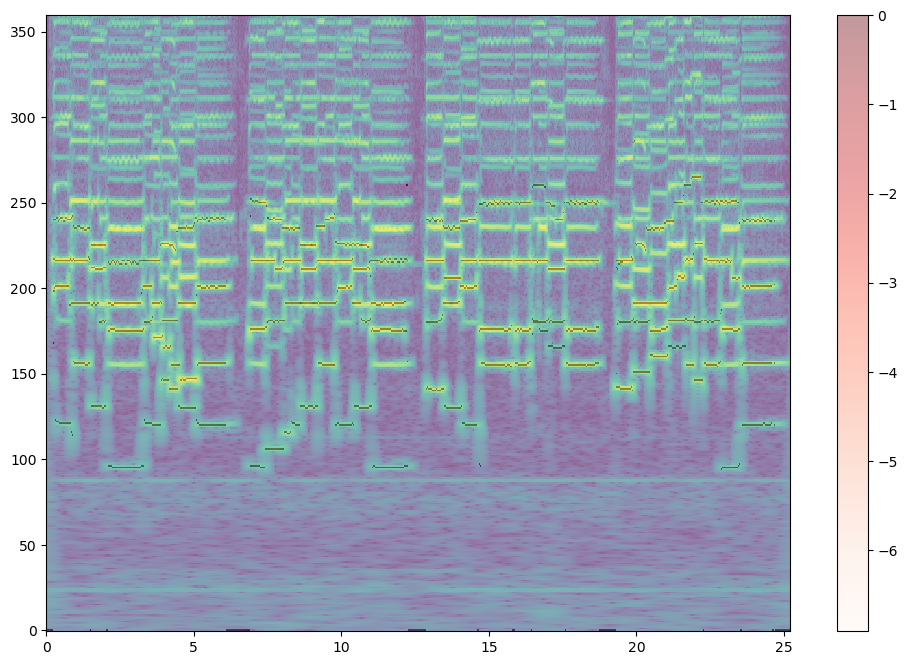

In [49]:
idx_file = 4
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
entry = data_d['collection']['entry'][idx_file]

cqt_d = Namespace()
cqt_d.value_3m, cqt_d.time_sec_v, cqt_d.frequency_hz_v = f_get_hcqt(audio_v, sr_hz)
cqt_d.f0_value_m = f_map_annot_frame_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['f0multi'])

# -------------------------------
plt.figure(figsize=(12,8));
D=1/2
plt.subplot(111); 
plt.imshow(flog(cqt_d.value_3m[1,:,:]), aspect='auto', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D]);
plt.imshow(flog(cqt_d.f0_value_m), aspect='auto', cmap='Reds', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D], alpha=0.4);
plt.colorbar();
# -------------------------------

### Segment-based (start, stop, value) f0 annotations

In [5]:
def f_map_annot_segment_based(cqt_time_sec_v, cqt_frequency_hz_v, segment_l):
    """
    Map f0 annotations to CQT frames and frequencies in the case the ground-truth is given as segment of notes

    Args:
        cqt_time_sec_v (nb_frame)
        cqt_frequency_hz_v (nb_freq)
        segment_l  a list of segments each is a dictionary {'start': , 'stop:', 'value': }
            value is given in midi-float unit
    Returns:
        cqt_f0_value_m (nb_freq, nb_frame)
    """
     
    cqt_f0_value_m = np.zeros( (len(cqt_frequency_hz_v), len(cqt_time_sec_v)) )
    for note_d in segment_l:
        pos_start = np.argmin(np.abs(note_d['time']-cqt_time_sec_v))
        pos_stop = np.argmin(np.abs(note_d['time']+note_d['duration']-cqt_time_sec_v))
        pos_value = np.argmin(np.abs(midi_to_f0(note_d['value'])-cqt_frequency_hz_v))
        cqt_f0_value_m[pos_value,pos_start:pos_stop ] = 1
    return cqt_f0_value_m

#### Test map annotations

MAPS_MUS-chp_op31_AkPnBcht.wav
{'filepath': [{'value': 'MAPS_MUS-chp_op31_AkPnBcht.wav'}], 'pitchmidi': [{'value': 58, 'time': 0.500943, 'duration': 0.44940499999999994}, {'value': 46, 'time': 0.500943, 'duration': 0.44940499999999994}, {'value': 57, 'time': 0.949449, 'duration': 0.07144100000000009}, {'value': 45, 'time': 0.949449, 'duration': 0.07144100000000009}, {'value': 58, 'time': 1.02089, 'duration': 0.07142999999999988}, {'value': 46, 'time': 1.02089, 'duration': 0.07142999999999988}, {'value': 61, 'time': 1.09232, 'duration': 0.07142000000000004}, {'value': 49, 'time': 1.09232, 'duration': 0.07142000000000004}, {'value': 65, 'time': 1.16374, 'duration': 0.11363999999999996}, {'value': 53, 'time': 1.16374, 'duration': 0.11363999999999996}, {'value': 57, 'time': 1.61829, 'duration': 0.07142000000000004}, {'value': 45, 'time': 1.61829, 'duration': 0.07142000000000004}, {'value': 58, 'time': 1.68971, 'duration': 0.07142999999999988}, {'value': 46, 'time': 1.68971, 'duration': 0.0

(400.0, 410.0)

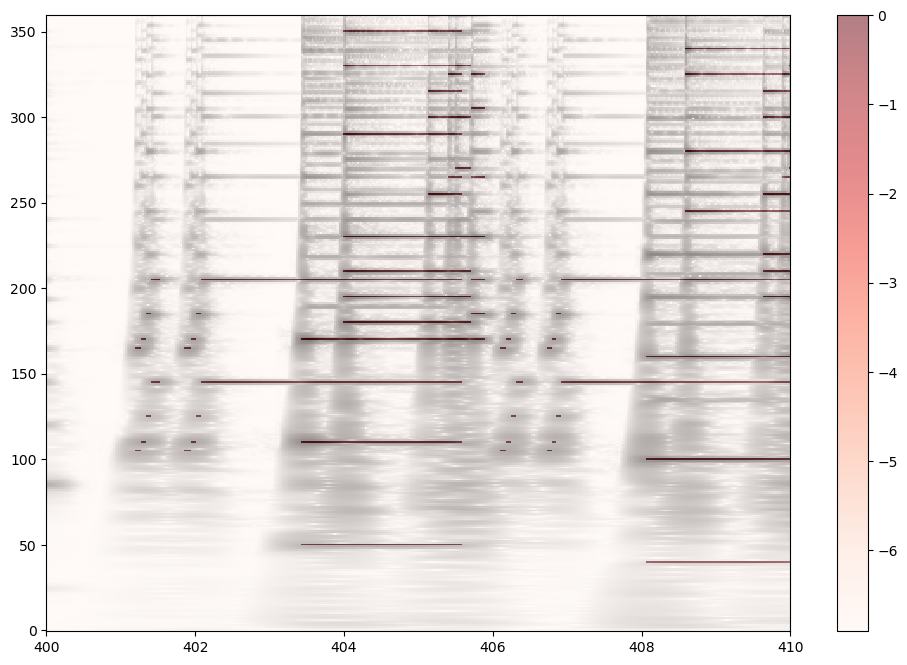

In [93]:
idx_file = 4
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']
entry = data_d['collection']['entry'][idx_file]
print(audiofile_l[idx_file])
print(entry)

cqt_d = Namespace()
cqt_d.value_3m, cqt_d.time_sec_v, cqt_d.frequency_hz_v = f_get_hcqt(audio_v, sr_hz)
cqt_d.f0_value_m = f_map_annot_segment_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['pitchmidi'])

# -------------------------------
plt.figure(figsize=(12,8));
D=1/2
plt.subplot(111); 
plt.imshow(flog(cqt_d.value_3m[1,:,:]), aspect='auto', cmap='gray_r', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D]);
plt.imshow(flog(cqt_d.f0_value_m), aspect='auto', cmap='Reds', origin='lower', interpolation='none', extent=[cqt_d.time_sec_v[0], cqt_d.time_sec_v[-1], 0-D, len(cqt_d.frequency_hz_v)-D], alpha=0.5);
plt.colorbar();
plt.xlim((400,410))
# -------------------------------

## Get dataloader

Do a generic dataloader which takes as input file_hdf5, file_pyjama, the keys to use for y, the method to use for feature extraction

In [6]:
patch_d = Namespace()
patch_d.L_frame = 64
patch_d.STEP_frame = int(patch_d.L_frame/2)

def f_get_patches(T, L, S):
    """
    description
    """
    # --- patch_d.L_frame+(nb_patch-1)*patch_d.STEP_frame < nb_frame
    nb_patch = int(np.floor((T - L)/S + 1))
    return [{'start_frame': (num_patch*S), 'end_frame': (num_patch*S)+L} for num_patch in range(nb_patch)]

#f_get_patches(250, patch_d.L_frame, patch_d.STEP_frame)


In [2]:
class PitchDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_feat_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        # --- only keep entries with annotation field 'f0multi'
        if do_f0_annot_frame1_segment2==1:
            entry_l = [entry for entry in entry_l if len(entry['f0multi'])]

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]

        #self.audiofile_l = self.audiofile_l[:32]

        self.feature_d = {}
        self.patch_l = []
        
        audio_d = Namespace()
        cqt_d = Namespace()
        gt_d = Namespace()

        with h5py.File(hdf5_feat_file, 'r') as feat_fid:
            for entry in entry_l:
                audio_d.file = entry['filepath'][0]['value']
                print(audio_d.file)
                
                cqt_d.value_3m = feat_fid['/' +  audio_d.file + '/cqt_value_3m/'][:]
                cqt_d.time_sec_v = feat_fid['/' +  audio_d.file + '/cqt_time_sec_v/'][:]
                cqt_d.frequency_hz_v = feat_fid['/' +  audio_d.file + '/cqt_frequency_hz_v/'][:]

                if do_f0_annot_frame1_segment2==1:
                    cqt_d.f0_value_m = f_map_annot_frame_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['f0multi'])
                elif do_f0_annot_frame1_segment2==2:
                    cqt_d.f0_value_m = f_map_annot_segment_based(cqt_d.time_sec_v, cqt_d.frequency_hz_v, entry['pitchmidi'])


                self.feature_d[audio_d.file] = {'X': torch.tensor(cqt_d.value_3m).float(), 'y': torch.tensor(cqt_d.f0_value_m)}
                
                localpatch_l = f_get_patches(cqt_d.value_3m.shape[2], patch_d.L_frame, patch_d.STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_d.file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })
            self.cqt_d_frequency_hz_v = cqt_d.frequency_hz_v
            
    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']
        X = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['X'][:,:, s:e]
        y = self.feature_d[ self.patch_l[idx_patch]['audiofile'] ]['y'][:,s:e]
        return {'X':X , 'y':y}
    
train_dataset = PitchDataset(hdf5_feat_file, pyjama_annot_file, do_train=True)
valid_dataset = PitchDataset(hdf5_feat_file, pyjama_annot_file, do_train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=9)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=9)

NameError: name 'Dataset' is not defined

### TEST

71561
torch.Size([32, 6, 360, 64])
torch.Size([32, 360, 64])


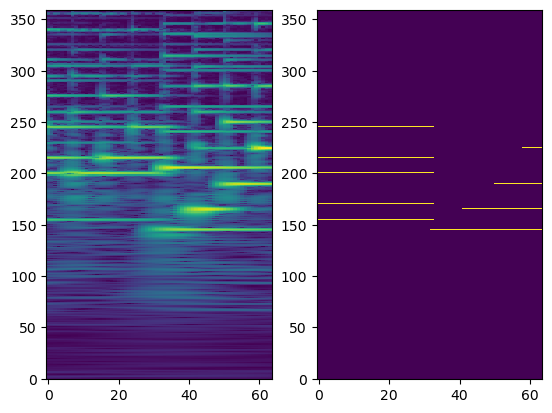

In [8]:
print(len(train_dataset))

idx_path = 51
plt.subplot(121); plt.imshow(flog(train_dataset[idx_path]['X'][1,:,:]).numpy(), aspect='auto', origin='lower', interpolation='none', );
plt.subplot(122); plt.imshow(train_dataset[idx_path]['y'][:,:].numpy(), aspect='auto', origin='lower', interpolation='none', );


print(next(iter(train_loader))['X'].size())
print(next(iter(train_loader))['y'].size())

## Get model

### UNet-model (based on Doras)

In [9]:
do_skip = True
do_verbose = False

class PitchUNet(nn.Module):
    """ 
    """
    def __init__(self):
        super(PitchUNet, self).__init__()

        encoder_l = []
        prev_channel = 6
        n_c_l = [64, 128, 256, 512]
        for n_c in n_c_l:
            layer_l = []
            layer_l.append( nn.BatchNorm2d(prev_channel) )
            layer_l.append( nn.Conv2d(in_channels=prev_channel, out_channels=n_c, kernel_size=(3,3), padding='same') )
            prev_channel = n_c
            layer_l.append( nn.Conv2d(in_channels=prev_channel, out_channels=n_c, kernel_size=(3,3), padding='same') )
            if n_c > 64:
                layer_l.append( nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) )
            layer_l.append( nn.ReLU() )

            encoder_l.append( nn.Sequential (*layer_l) )

        self.encoder = nn.ModuleList(encoder_l)

        decoder_l = []
        prev_channel = 512
        n_c_l = [256, 128, 64, 1]
        for n_c in n_c_l:
            if do_skip:  # --- If skip-connections
                prev_channel = 2*prev_channel
            layer_l = []
            layer_l.append( nn.BatchNorm2d(prev_channel) )
            if n_c > 1:
                layer_l.append( nn.ConvTranspose2d(in_channels=prev_channel, out_channels=n_c, kernel_size=(2,2), stride=(2,2)) )
                prev_channel = n_c
            layer_l.append( nn.Conv2d(in_channels=prev_channel, out_channels=n_c, kernel_size=(3,3), padding='same') )
            prev_channel = n_c
            layer_l.append( nn.Conv2d(in_channels=prev_channel, out_channels=n_c, kernel_size=(3,3), padding='same') )
            if n_c > 1:
                layer_l.append( nn.ReLU() )
            
            decoder_l.append( nn.Sequential (*layer_l) )
            prev_channel = n_c

        self.decoder = nn.ModuleList(decoder_l)

    def forward(self, x):
        # input is (batch, channels, freq=360, time=50)
        encoder_d = {}
        encoder_d[0] = x
        for idx_e, layer in enumerate(self.encoder):
            if do_verbose: print(f'e{idx_e}: {encoder_d[idx_e].size()}')
            encoder_d[idx_e+1] = layer( encoder_d[idx_e] )
            if do_verbose: print(f'\t -> e{idx_e+1}: {encoder_d[idx_e+1].size()}')
        
        if do_verbose: print('-------------------')

        decoder_d = {}
        decoder_d[0] = encoder_d[idx_e+1]
        for idx_d, layer in enumerate(self.decoder):
            if do_verbose: print(f'd{idx_d}: {decoder_d[idx_d].size()}')
            if do_skip:
                if do_verbose: print(f'+e{idx_e-idx_d+1}: {encoder_d[idx_e-idx_d+1].size()}')
                input = torch.cat( (decoder_d[idx_d], encoder_d[idx_e-idx_d+1]), dim=1)
                if do_verbose: print(f'=: {input.size()}')
            else:
                input = decoder_d[idx_d]
            decoder_d[idx_d+1] = layer( input )

            if do_verbose: print(f'\t -> d{idx_d+1}: {decoder_d[idx_d+1].size()}')

        return decoder_d[idx_d+1]
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PitchUNet().to(device)
print(model)

import torchsummary
torchsummary.summary(model, (6, 360, 64))



PitchUNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
    )
    (1): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
    )
    (2): Sequential(
      (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): MaxPool2d(kernel_

### ConvNet-model (based on Bittner)

In [98]:
config_l = [
    [128, (5,5), 'relu'],
    [64, (5,5), 'relu'],
    [64, (3,3), 'relu'],
    [64, (3,3), 'relu'],
    [8, (70,3), 'relu'],
    [1, (1,1), ''], # no sigmoid at the end here, because we are using BCEWithLogitsLoss
    ]

class PitchSalience(nn.Module):
    """ 
    """
    def __init__(self):
        super(PitchSalience, self).__init__()

        prev_channel = 6
        layers = []

        for config in config_l:
            layers.append( nn.BatchNorm2d(prev_channel) )
            layers.append( nn.Conv2d(in_channels=prev_channel, out_channels=config[0], kernel_size=config[1], padding='same') )
            if len(config[2]) > 0: layers.append(nn.ReLU())

            prev_channel = config[0]

        self.layers = nn.ModuleList(layers)


    def forward(self, x):
        # input is (batch, channels, freq=360, time=50)
        for layer in self.layers:
            x = layer(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PitchSalience().to(device)

import torchsummary
torchsummary.summary(model, (6, 360, 50))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1           [-1, 6, 360, 50]              12
            Conv2d-2         [-1, 128, 360, 50]          19,328
              ReLU-3         [-1, 128, 360, 50]               0
       BatchNorm2d-4         [-1, 128, 360, 50]             256
            Conv2d-5          [-1, 64, 360, 50]         204,864
              ReLU-6          [-1, 64, 360, 50]               0
       BatchNorm2d-7          [-1, 64, 360, 50]             128
            Conv2d-8          [-1, 64, 360, 50]          36,928
              ReLU-9          [-1, 64, 360, 50]               0
      BatchNorm2d-10          [-1, 64, 360, 50]             128
           Conv2d-11          [-1, 64, 360, 50]          36,928
             ReLU-12          [-1, 64, 360, 50]               0
      BatchNorm2d-13          [-1, 64, 360, 50]             128
           Conv2d-14           [-1, 8, 

### Test models

In [10]:
batch = next(iter(train_loader))
X = batch['X'].to(device)
y = batch['y'].to(device)
hat_y = model(X)
print(f'{X.size()} {y.size()} {hat_y.squeeze(1).size()}')


torch.Size([32, 6, 360, 64]) torch.Size([32, 360, 64]) torch.Size([32, 360, 64])


In [11]:
nn.BCEWithLogitsLoss(reduction='none')(hat_y.squeeze(1), y).size()

torch.Size([32, 360, 64])

## Training using torchlighning

In [12]:
train_config_d = {}
project_name = 'wandb_pitch'
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d-%H-%M-%S")
expe_name = formatted_datetime
print(expe_name)
WORK_DIR = './'
wandb.finish()
wandb_logger = WandbLogger(project = project_name, name = expe_name, save_dir = WORK_DIR )
wandb_logger.experiment.config.update(train_config_d)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2024-07-16-12-14-36


wandb: Currently logged in as: geoffroy-peeters (adasp). Use `wandb login --relogin` to force relogin


In [13]:
class PitchLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        out = batch
        hat_y = self.model(out['X'])
        loss = self.loss(hat_y.squeeze(1), out['y'])
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        out = batch
        hat_y = self.model(out['X'])
        loss = self.loss(hat_y.squeeze(1), out['y'])
        self.log("valid_loss", loss)

        if batch_idx==0: 
            data_image = np.hstack( (out['y'][0,:,:].cpu().numpy(),  nn.Sigmoid()(hat_y[0,0,:,:].detach()).cpu().numpy() ) )
            wandb.log({'val3/f0': wandb.Image( data_image )})
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.001)
        return optimizer

In [14]:
print(next(model.parameters()).device)

cuda:0


In [15]:
my_lighting = PitchLigthing(model)
early_stop_callback = EarlyStopping(monitor="valid_loss", patience=3, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', dirpath='model_pitch/', filename='best_model', save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  logger = wandb_logger, max_epochs = 500, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_loader, val_dataloaders=valid_loader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/callback

Epoch 0: 100%|██████████| 2237/2237 [15:17<00:00,  2.44it/s, v_num=sk2e]   

Metric valid_loss improved. New best score: 0.017


Epoch 1: 100%|██████████| 2237/2237 [15:23<00:00,  2.42it/s, v_num=sk2e]

Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.014


Epoch 2: 100%|██████████| 2237/2237 [15:23<00:00,  2.42it/s, v_num=sk2e]

Metric valid_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.013


Epoch 3: 100%|██████████| 2237/2237 [15:23<00:00,  2.42it/s, v_num=sk2e]

Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.011


Epoch 4: 100%|██████████| 2237/2237 [15:23<00:00,  2.42it/s, v_num=sk2e]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.011


Epoch 6: 100%|██████████| 2237/2237 [14:10<00:00,  2.63it/s, v_num=sk2e]

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Evaluate results

- What are the performance measures ?

- Using mir_eval


In [17]:
best_model_path = checkpoint_callback.best_model_path
best_model_path = 'model_pitch/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = PitchLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model

Best model saved at: my_model/best_model.ckpt


RuntimeError: Error(s) in loading state_dict for PitchLigthing:
	Missing key(s) in state_dict: "model.encoder.0.0.weight", "model.encoder.0.0.bias", "model.encoder.0.0.running_mean", "model.encoder.0.0.running_var", "model.encoder.0.1.weight", "model.encoder.0.1.bias", "model.encoder.0.2.weight", "model.encoder.0.2.bias", "model.encoder.1.0.weight", "model.encoder.1.0.bias", "model.encoder.1.0.running_mean", "model.encoder.1.0.running_var", "model.encoder.1.1.weight", "model.encoder.1.1.bias", "model.encoder.1.2.weight", "model.encoder.1.2.bias", "model.encoder.2.0.weight", "model.encoder.2.0.bias", "model.encoder.2.0.running_mean", "model.encoder.2.0.running_var", "model.encoder.2.1.weight", "model.encoder.2.1.bias", "model.encoder.2.2.weight", "model.encoder.2.2.bias", "model.encoder.3.0.weight", "model.encoder.3.0.bias", "model.encoder.3.0.running_mean", "model.encoder.3.0.running_var", "model.encoder.3.1.weight", "model.encoder.3.1.bias", "model.encoder.3.2.weight", "model.encoder.3.2.bias", "model.decoder.0.0.weight", "model.decoder.0.0.bias", "model.decoder.0.0.running_mean", "model.decoder.0.0.running_var", "model.decoder.0.1.weight", "model.decoder.0.1.bias", "model.decoder.0.2.weight", "model.decoder.0.2.bias", "model.decoder.0.3.weight", "model.decoder.0.3.bias", "model.decoder.1.0.weight", "model.decoder.1.0.bias", "model.decoder.1.0.running_mean", "model.decoder.1.0.running_var", "model.decoder.1.1.weight", "model.decoder.1.1.bias", "model.decoder.1.2.weight", "model.decoder.1.2.bias", "model.decoder.1.3.weight", "model.decoder.1.3.bias", "model.decoder.2.0.weight", "model.decoder.2.0.bias", "model.decoder.2.0.running_mean", "model.decoder.2.0.running_var", "model.decoder.2.1.weight", "model.decoder.2.1.bias", "model.decoder.2.2.weight", "model.decoder.2.2.bias", "model.decoder.2.3.weight", "model.decoder.2.3.bias", "model.decoder.3.0.weight", "model.decoder.3.0.bias", "model.decoder.3.0.running_mean", "model.decoder.3.0.running_var", "model.decoder.3.1.weight", "model.decoder.3.1.bias", "model.decoder.3.2.weight", "model.decoder.3.2.bias". 
	Unexpected key(s) in state_dict: "model.layers.0.weight", "model.layers.0.bias", "model.layers.0.running_mean", "model.layers.0.running_var", "model.layers.0.num_batches_tracked", "model.layers.1.weight", "model.layers.1.bias", "model.layers.3.weight", "model.layers.3.bias", "model.layers.3.running_mean", "model.layers.3.running_var", "model.layers.3.num_batches_tracked", "model.layers.4.weight", "model.layers.4.bias", "model.layers.6.weight", "model.layers.6.bias", "model.layers.6.running_mean", "model.layers.6.running_var", "model.layers.6.num_batches_tracked", "model.layers.7.weight", "model.layers.7.bias", "model.layers.9.weight", "model.layers.9.bias", "model.layers.9.running_mean", "model.layers.9.running_var", "model.layers.9.num_batches_tracked", "model.layers.10.weight", "model.layers.10.bias", "model.layers.12.weight", "model.layers.12.bias", "model.layers.12.running_mean", "model.layers.12.running_var", "model.layers.12.num_batches_tracked", "model.layers.13.weight", "model.layers.13.bias", "model.layers.15.weight", "model.layers.15.bias", "model.layers.15.running_mean", "model.layers.15.running_var", "model.layers.15.num_batches_tracked", "model.layers.16.weight", "model.layers.16.bias". 

torch.Size([32, 6, 360, 64]) torch.Size([32, 360, 64]) torch.Size([32, 1, 360, 64])


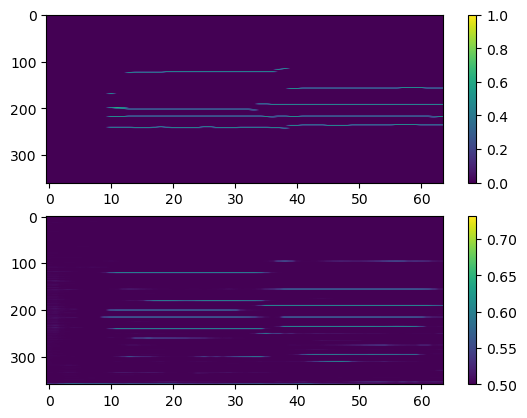

In [65]:
model.to(device)
data = next(iter(valid_loader))

hat_y = nn.Sigmoid()( model(data['X'].to(device)) )

print(f"{data['X'].size()} {data['y'].size()} {hat_y.size()}")

idx_patch = 0
plt.subplot(211); plt.imshow(data['y'][idx_patch,:,:].cpu().numpy(), aspect='auto'); plt.colorbar()
plt.subplot(212); plt.imshow(nn.Sigmoid()(hat_y[idx_patch,0,:,:].detach()).cpu().numpy(), aspect='auto'); plt.colorbar()

### Evaluate results with mir_eval

In [67]:
import mir_eval
threshold = 0.5

model.to(device)

store_l = []
for data in valid_loader:
    hat_y = nn.Sigmoid()( model(data['X'].to(device)) )
    
    nb_patch = hat_y.size(0)
    for idx_patch in range(nb_patch):
        gt_m = data['y'][idx_patch,:,:].cpu().numpy()
        est_m = hat_y[idx_patch,0,:,:].detach().cpu().numpy()
        ref_time_l, est_time_l, ref_freqs_l, est_freqs_l = [], [], [], []
        for t in range(gt_m.shape[1]):
            ref_time_l.append( float(t) )
            ref_freqs_l.append( valid_dataset.cqt_d_frequency_hz_v[ gt_m[:,t]>0 ] )
            est_time_l.append( float(t) )
            est_freqs_l.append( valid_dataset.cqt_d_frequency_hz_v[ est_m[:,t]>threshold ] )

        ref_time_l = np.array(ref_time_l)
        est_time_l = np.array(est_time_l)

        dict_d = mir_eval.multipitch.evaluate(ref_time_l, ref_freqs_l, est_time_l, est_freqs_l)
        store_l.append({'Accuracy': dict_d['Accuracy'], 'gt_m': gt_m,  'est_m': est_m})
print(len(store_l))

75


0.5774223285865806


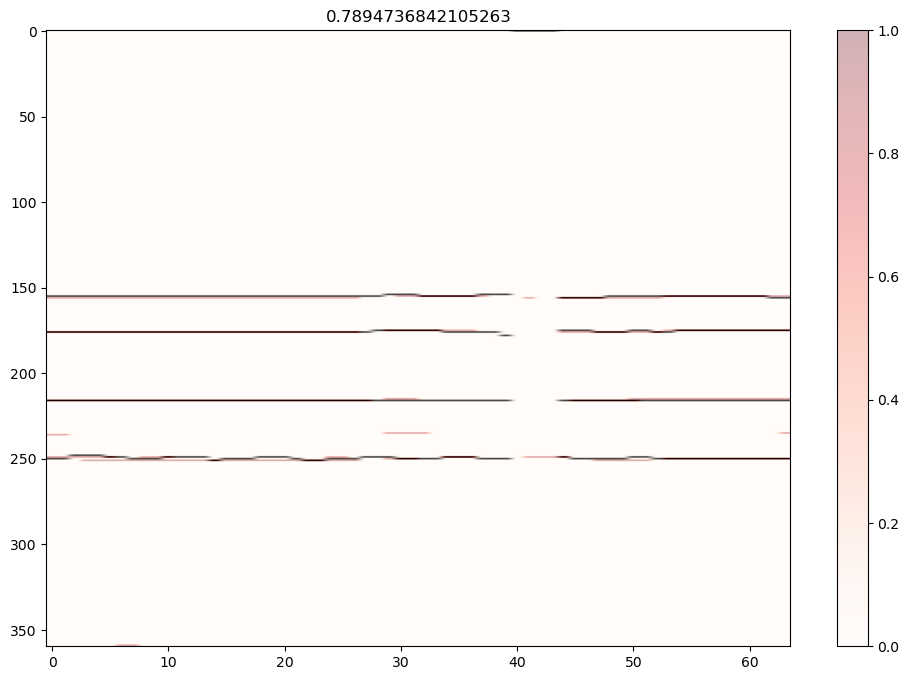

In [85]:
# Bittner: 72.1%
# Doras: 
print( np.mean([store['Accuracy'] for store in store_l]) )
pos = np.argmax([store['Accuracy'] for store in store_l])
plt.figure(figsize=(12,8));
plt.subplot(111); 
plt.imshow(store_l[pos]['gt_m'], cmap='gray_r', aspect='auto'); 
plt.imshow(store_l[pos]['est_m']>0.5, cmap='Reds', aspect='auto', alpha=0.3); 
plt.colorbar()
plt.title(store_l[pos]['Accuracy']);